In [13]:
import geopandas as gpd
import pandas as pd
import s3fs
import numpy as np
import math
from shapely.geometry import Polygon, box
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

# 1. Read Observation Data into Geopandas Frame

In [14]:
DATASET_PATH = '../data/full_dataset.csv'
RASTER_PATH = '../data/rasters/'
PKL_PATH = '../data/labels/ca/'

In [15]:

BUCKET_NAME = 'datasets-sdm'
folder = 'geoLifeCLEF/observations'
train_file, test_file = 'observations_us_train.csv', 'observations_us_test.csv'
s3_train_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, train_file)

In [16]:
train_usa = pd.read_csv(s3_train_path,header='infer', sep=';',)
train_usa.head()

,observation_id,latitude,longitude,species_id,subset
0,20000173,33.197660,-116.180680,4911,train
1,20000175,34.037968,-118.876755,4912,train
2,20000176,27.620740,-97.222690,4913,train
3,20000177,29.155582,-95.653930,4914,train
4,20000179,36.605740,-121.959510,4915,train


In [17]:
train_df, val_df = train_usa[train_usa.subset == 'train'], train_usa[train_usa.subset == 'val']
len(train_df), len(val_df)

(931132, 25099)

In [18]:
del train_usa

In [19]:
train_gdf = gpd.GeoDataFrame(train_df, geometry=gpd.points_from_xy(train_df.longitude, train_df.latitude))\
                .drop(['latitude', 'longitude'], axis=1).set_crs(4326)
# train_gdf.to_crs
train_gdf.head()

,observation_id,species_id,subset,geometry
0,20000173,4911,train,POINT (-116.18068 33.19766)
1,20000175,4912,train,POINT (-118.87676 34.03797)
2,20000176,4913,train,POINT (-97.22269 27.62074)
3,20000177,4914,train,POINT (-95.65393 29.15558)
4,20000179,4915,train,POINT (-121.95951 36.60574)


In [20]:
train_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

# 2. Create grid for CA (AOI)

## 2.1 Use a generic map outline for the California

Downloaded from [Diva GIS](https://www.diva-gis.org/gdata)

In [24]:
import geopandas as gpd

ca_path = '../data/USA_adm/USA_adm1.shp'
usa_map = gpd.read_file(ca_path)
# world_filepath = gpd.datasets.get_path('naturalearth_lowres')
# world = gpd.read_file(world_filepath)
usa_map.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,TYPE_1,ENGTYPE_1,NL_NAME_1,VARNAME_1,geometry
0,244,USA,United States,1,Alabama,State,State,None,AL|Ala.,"MULTIPOLYGON (((-88.11320 30.22623, -88.11291 ..."
1,244,USA,United States,2,Alaska,State,State,None,AK|Alaska,"MULTIPOLYGON (((-179.13147 51.20972, -179.1322..."
2,244,USA,United States,2,Alaska,State,State,None,AK|Alaska,"MULTIPOLYGON (((-141.31459 60.05416, -141.3125..."
3,244,USA,United States,3,Arizona,State,State,None,AZ|Ariz.,"POLYGON ((-110.53930 37.00423, -110.47991 37.0..."
4,244,USA,United States,4,Arkansas,State,State,None,AR|Ark.,"POLYGON ((-93.36903 36.49686, -93.36530 36.496..."


<AxesSubplot:>

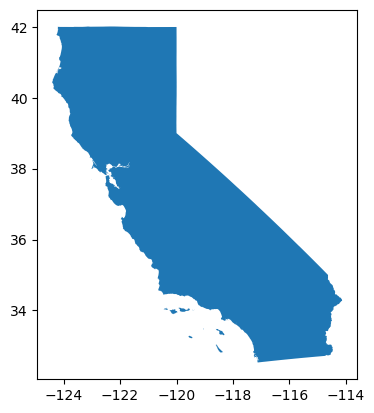

In [25]:
ca_map = usa_map[usa_map['NAME_1'] == 'California']
ca_map.plot()

# 3. Species Level Kernel Function

## 3.1 Extract one species to test with

In [12]:
species_id_counts = train_df.species_id.value_counts()
species_id_counts.min()

1

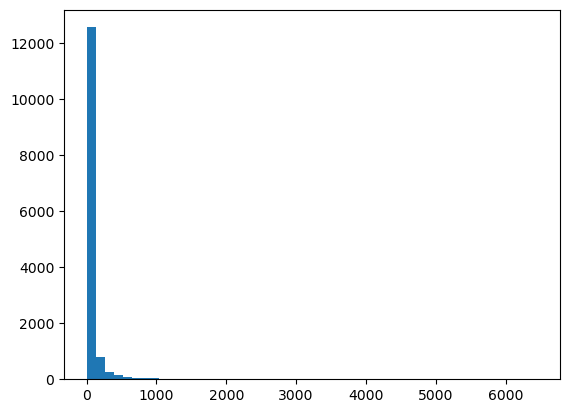

In [13]:
plt.hist(species_id_counts, bins=50)
plt.show()

# 4. Build a class with all the data and functions needed for gridding and kernels

In [26]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
#Run this to reload the python file
%autoreload 2
from grid_dask import *


In [10]:
shutdown_all_clusters()

In [53]:
# cluster, client = setup_dask_cluster(max=113,mem=32)
cluster, client = setup_dask_cluster(max=50,mem=32, adapt=False)

Clusters already exist, latching onto the first one
<Client: 'tls://10.244.26.17:8786' processes=20 threads=20, memory=640.00 GiB>
https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.b8144036b6fa4ed38a9ccccf32a8e7b5/status


In [54]:
grid_res = 0.05
obs_ca = Observations(train_gdf, ca_map, grid_res_deg=grid_res)

Number of classes in entire dataset:  14124
Gridding..
Creating Land Mask..
Num entries before masking:  39936
Num entries after masking:  17173
Clipping observation to AOI..
Number of classes in AOI dataset:  5079
(17173, 2)


In [55]:
obs_ca.grid_gd.head()

,geometry,grid_id
0,"POLYGON ((-124.36556 40.23088, -124.36556 40.2...",0
1,"POLYGON ((-124.36556 40.28088, -124.36556 40.3...",1
2,"POLYGON ((-124.36556 40.33088, -124.36556 40.3...",2
3,"POLYGON ((-124.36556 40.38088, -124.36556 40.4...",3
4,"POLYGON ((-124.36556 40.43088, -124.36556 40.4...",4


In [56]:
obs_ca.gdf_obs.head()

,observation_id,species_id,subset,geometry,valid
0,20000173,4911,train,POINT (-116.18068 33.19766),True
1,20000175,4912,train,POINT (-118.87676 34.03797),True
12,20000189,4922,train,POINT (-116.94504 32.72591),True
13,20000190,4923,train,POINT (-117.84243 33.66103),True
16,20000198,2329,train,POINT (-118.16702 34.13520),True


Text(0.5, 1.0, 'Gridding at 0.05 degrees')

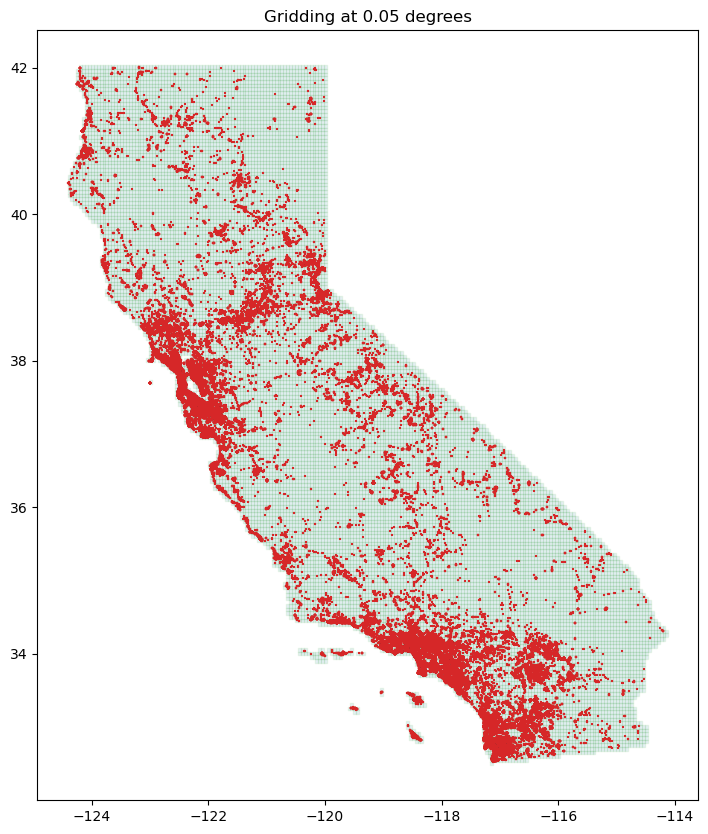

In [57]:
fig, ax = plt.subplots(figsize=(10,10))
obs_ca.grid_gd.plot(ax=ax, edgecolor = 'tab:green', alpha=0.1)
obs_ca.gdf_obs.plot(ax=ax, marker='+', markersize=1, color='tab:red')
ax.set_title('Gridding at {:} degrees'.format(grid_res))

In [58]:
del train_gdf

### Optimized grid testing

In [ ]:
unique, counts = np.unique(obs_usa.land_mask, return_counts=True)

#display unique values and counts side by side
print(np.asarray((unique, counts)).T)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
obs_usa.grid_gd.plot(ax=ax, column='mask', edgecolor = 'none', legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
# usa.plot(ax=ax,  color='none')
# train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

In [ ]:
w = usa.simplify(0.1).geometry
w.iloc[0]

In [ ]:
series = obs_usa.grid_gd.within(w.iloc[0]).to_numpy()

unique, counts = np.unique(series, return_counts=True)

#display unique values and counts side by side
print(np.asarray((unique, counts)).T)

In [ ]:
obs_usa.grid_gd.loc[5510:5520].geometry.centroid

In [ ]:
obs_usa.grid_np[5510:5521]

### Combine chosen_species_grid into the primary observations grid with the following structures:

**Possibility A: Per observation**

| SpeciesID | Probability | GridID | Geometry |
| --- | --- | --- | --- |
| 115 | 0.7 | 7743 | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |


Or

**Possibility B: Per Grid**

| SpeciesID | SpeciesID | ... | SpeciesID | GridID | Geometry |
| --- | --- | --- | --- | --- | --- |
| 115 | 4443 | ... | 19328 | 52  | POLYGON ((-112.48721 34.48000, -112.48721 34.5... |

We pick option A, since it provides a more memory efficient method

## Grid and KDE all species

In [59]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.b8144036b6fa4ed38a9ccccf32a8e7b5/status,


## Dask KDE Functions

In [63]:
import dask
def kernel_per_species(grid_gd, grid_np, gdf_chosen, 
                       kde:bool=True, chosen_id:int=0, cumulative:bool=False, 
                       radius:float=0.5, kernel:str='gaussian', q:int=8):

    """
    Inputs:
    kde: whether or not to apply KDE
        if False: only group observations within a cell
        if True: group and then apply KDE
    chosen_id: Species ID for a single chosen species
    grid: grid to which these observations must conform
    radius: radius in degrees for the kernel function
    kernel: 'linerar' / 'epanechnikov' / 'gaussian' ..
    cumulative: keep adding to a master species list -> grid_kde
    Quantization: whether or not to quantize to some int value : 8,16,32,64

    Output:

    """
    # Remove duplicate counts
    # With intersect, those that fall on a boundary will be allocated to all cells that share that boundary
    # chosen_species_grid = chosen_species_grid.drop_duplicates(subset = ['speciesID']).reset_index(drop = True)

    chosen_species_grid = gpd.sjoin(gdf_chosen, grid_gd, how='inner', predicate='within').drop(['index_right'], axis=1)
    # display(chosen_species_grid)

    # Add a field with constant value of 1
    chosen_species_grid['num_obs'] = 1.0

    # Group GeoDataFrame by cell while aggregating the Count values
    chosen_species_grid = chosen_species_grid.groupby('grid_id').agg({'num_obs':'sum'})

    chosen_species_grid = grid_gd.merge(chosen_species_grid, on = 'grid_id', how = "right")

    if (kde and radius*2 > grid_res):

        #List of grids that have observations for this species
        chosen_grids = list(chosen_species_grid['grid_id'])
        # print(chosen_grids, chosen_species_grid)
        #sanity check
        if len(chosen_grids) == 0:
            return 

        # Create training set for KDE
        x_train = grid_np[chosen_grids,:]
        y_train = chosen_species_grid['num_obs'].to_numpy()


        tree = KDTree(x_train)
        y_hat = tree.kernel_density(grid_np, h=radius, kernel=kernel)*(1*(radius**2))

        # y_hat /= y_hat.max()
        # print("Max y_hat = ", y_hat.max())
        #Cap all cells at 1
        y_hat[y_hat > 1.0] = 1.0
        y_hat[y_hat < 1e-5] = 0.0
        
        if (q > 0):
            #let's say by default it's int8
            y_hat = (y_hat * 255).astype('uint8')

        return y_hat


                   
def kde(obs, classes, radius:float=1.0, kernel:str='gaussian'):
    """Populates the grid_kde data structure
       with 1 column per species_id for every grid_cell
       **fingers crossed**
    """
    y_hats = []
    
    # grid_gd = obs.grid_gd
    # grid_np = obs.grid_np
    # gdf_obs = obs.gdf_obs
    
    #Trying this
    #SUPER CRUCIAL for memory and speedup!
    grid_gd = dask.delayed(obs.grid_gd)
    grid_np = dask.delayed(obs.grid_np)

    # print("Building Parallel Compute Graph")

    for id in classes:
        gdf_chosen = dask.delayed(obs.gdf_obs[obs.gdf_obs.species_id==id])
        # gdf_chosen = obs.gdf_obs[obs.gdf_obs.species_id==id]
        y_hats.append(dask.delayed(kernel_per_species)(grid_gd=grid_gd, grid_np=grid_np, gdf_chosen=gdf_chosen, 
                                         kde=True, chosen_id=id, radius=radius, kernel=kernel, cumulative=True))
    # print("Ready for parallel compute...")
    return y_hats   

def requantize_batch(arr, q:int=8):
    out = []
    denom = 2**q - 1
    for a in arr:
        out.append(a.astype('float16')/denom)
        
    return out

In [33]:
# obs_usa.class_list
classes = obs_ca.class_list[0:20]


In [34]:
# cluster.scale(100)
# prob_kde = dask.delayed(kde)(obs_usa,classes)
prob_kde = kde(obs_ca,classes)

In [35]:
prob_kde = dask.compute(prob_kde)

In [36]:
from sys import getsizeof

In [37]:
prob_kde[0][19].max(), prob_kde[0][0].dtype, getsizeof(prob_kde[0][19])

(255, dtype('uint8'), 419554)

In [38]:
prob_kde2 = requantize_batch(prob_kde[0])

In [39]:
prob_kde2[19].max(), len(prob_kde2[19]), getsizeof(prob_kde2[19])

(1.0, 419442, 838996)

## Break up the task into batches

In [64]:
total_classes, inc = len(obs_ca.class_list), 300

def set_classes(gdf, min_id, inc):
    max_id = min_id + inc

    if (max_id > total_classes):
        max_id = total_classes + 1
    
    print(min_id, max_id-1)
    return gdf.class_list[min_id:max_id]

print(total_classes, inc)

def batch(gdf, classes, radius='1.0', kernel='gaussian'):
    sub_results = []
    sub_results.append(kde(obs=gdf,classes=classes, radius=radius, kernel=kernel))
    return sub_results




batches = []

for i in range(0, total_classes+1, inc):
    classes = set_classes(obs_ca, i,inc)
    result_batch = batch(gdf=obs_ca, classes=classes, radius=0.5, kernel='epanechnikov')
    batches.append(result_batch)
    
print("Num Batches [1st index]: ", len(batches))
print("Num of classes in each batch (except last) []: ", inc)


5079 300
0 299
300 599
600 899
900 1199
1200 1499
1500 1799
1800 2099
2100 2399
2400 2699
2700 2999
3000 3299
3300 3599
3600 3899
3900 4199
4200 4499
4500 4799
4800 5079
Num Batches [1st index]:  17
Num of classes in each batch (except last) []:  300


In [65]:
##Be patient - takes about 1-2 mins to start on the cluster dashboard
kde_grids = dask.compute(batches) 

In [66]:
kde_grids[0][15][0][299].max()

162

In [67]:
len(kde_grids[0][0][0]), type(kde_grids[0][0][0][0]), kde_grids[0][0][0][1].shape, kde_grids[0][0][0][99]

(300, numpy.ndarray, (17173,), array([0, 0, 0, ..., 0, 0, 0], dtype=uint8))

In [68]:
len(kde_grids[0][1][0]), len(kde_grids[0])

(300, 17)

In [71]:
getsizeof(kde_grids[0][0][0][199]), total_classes

(17285, 5079)

## Unpack nested list

**Dimension 1 [0][b] : Batch number** -> Iterate over kde_grids[0][0:num_batches] in outermost loop -> List


**Dimension 4 [0][b][0][id] : Id number within that batch** -> Iterate over kde_grids[0][b][0][id]

In [72]:
def requantize(arr, q:int=8):
    out = []
    denom = 2**q - 1
    for a in arr:
        out.append(a.astype('float16')/denom)
        
    return out

In [73]:
#inc is the number of classes in each batch
# %%time
import warnings
warnings.filterwarnings('ignore')

kde_gdf = obs_ca.grid_gd.copy()

for i, batch in enumerate(kde_grids[0]):
    # print (i)
    for j, kde in enumerate(batch[0]):
        # print(j)
        class_index = inc*i + j
        chosen_id = obs_ca.class_list[class_index]
        col_name = 'prob_{}'.format(chosen_id)
        # print(col_name)
        kde_gdf[col_name] = kde
        # print (type(kde))
        

In [74]:
len(kde_gdf)

17173

In [75]:
kde_gdf.head()

,geometry,grid_id,prob_4911,prob_4912,prob_4922,prob_4923,prob_2329,prob_4927,prob_4930,prob_4382,...,prob_14228,prob_202,prob_9006,prob_272,prob_16726,prob_17029,prob_8230,prob_13366,prob_16533,prob_1455
0,"POLYGON ((-124.36556 40.23088, -124.36556 40.2...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((-124.36556 40.28088, -124.36556 40.3...",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((-124.36556 40.33088, -124.36556 40.3...",2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"POLYGON ((-124.36556 40.38088, -124.36556 40.4...",3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"POLYGON ((-124.36556 40.43088, -124.36556 40.4...",4,0,0,24,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
filename = "geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl"
filename = PKL_PATH + filename
kde_gdf.to_pickle(filename)


## Writing to S3 Bucket

In [82]:
BUCKET_NAME = 'datasets-sdm'
folder = 'kde/ca/'
s3_write_path = 's3://{}/{}/{}'.format(BUCKET_NAME, folder, filename)
print(s3_write_path)

s3://datasets-sdm/kde/ca//../data/labels/ca/geolifeclef_ca_0.05deg_kde_0.5deg_epanechnikov.pkl


In [83]:
kde_gdf.to_pickle(s3_write_path)

## Test reading back feather file

In [77]:
chosen_id = 4911
col_name = 'prob_{}'.format(chosen_id)

kde_gdf_unpkl = pd.read_pickle(filename)


In [78]:
type(kde_gdf_unpkl)

geopandas.geodataframe.GeoDataFrame

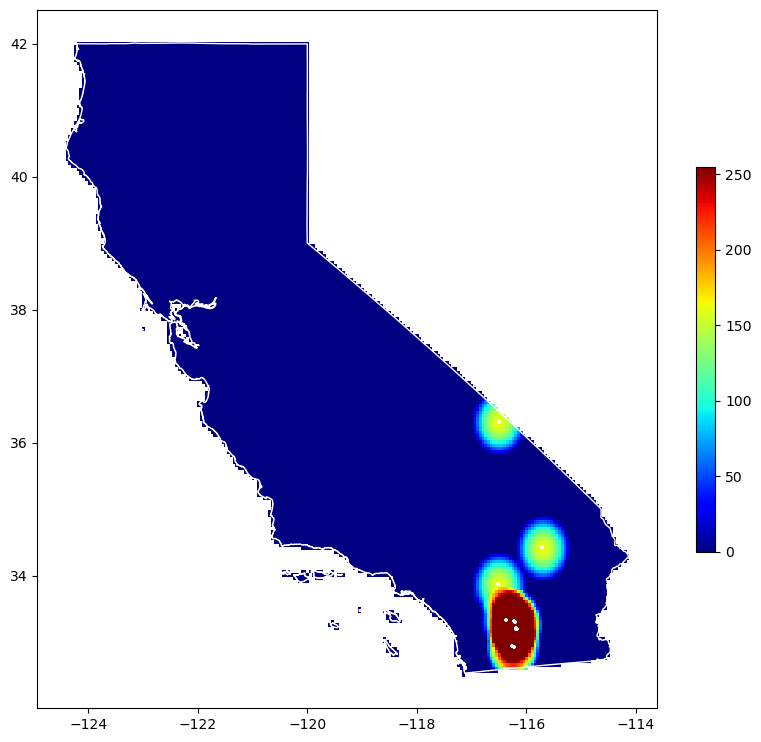

In [80]:
col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kde_gdf_unpkl.plot(ax=ax, column=col_name, edgecolor = 'none', legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
ca_map.plot(ax=ax,  color='none', edgecolor='white')
obs_ca.gdf_obs[obs_ca.gdf_obs.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

### If we wanted to save a new file for every batch for memory reasons, we would use this

[[UNTESTED]]

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')


# for i, batch in enumerate(kde_grids[0]):
#     # print (i)
#     kde_gdf = obs_usa.grid_gd.copy()
#     filename = "geolifeclef_usa_0.5deg_kde"
    
#     for j, kde in enumerate(batch[0]):
#         # print(j)
#         class_index = inc*i + j
#         chosen_id = obs_usa.class_list[class_index]
#         col_name = 'prob_{}'.format(chosen_id)
#         # print(col_name)
#         kde_gdf[col_name] = kde
#         # print (type(kde))
#     save_gdf()
        

## Memory cleanup

In [27]:
%whos

Variable                      Type              Data/Info
---------------------------------------------------------
BUCKET_NAME                   str               datasets-sdm
DATASET_PATH                  str               ../data/full_dataset.csv
KDTree                        type              <class 'sklearn.neighbors._kd_tree.KDTree'>
KernelDensity                 type              <class 'sklearn.neighbors._kde.KernelDensity'>
Observations                  type              <class 'grid_dask.Observations'>
Polygon                       type              <class 'shapely.geometry.polygon.Polygon'>
RASTER_PATH                   str               ../data/rasters/
batch                         list              n=1
batches                       list              n=48
box                           function          <function box at 0x7fa0f1b33910>
check_for_existing_clusters   function          <function check_for_exist<...>usters at 0x7fa0d0eab010>
chosen_id                     int64 

In [67]:
kde_grids = None
obs_usa = None
kde = None

In [72]:
import gc 
gc.collect()

565

In [68]:
del kde, kde_grids

In [71]:
del batches, batch

# Test Stuff

### TEST Displays
Let's take species ID: 115, that has 723 observations across the USA

In [ ]:
chosen_id = 115
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.0, kernel='gaussian', cumulative=True)

In [ ]:
obs_usa.grid_kde

In [ ]:
kernels = obs_usa.grid_kde

In [ ]:
col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kernels.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
plt.show()

#### Let's do a few more and make it cumulative

In [ ]:
chosen_id = 4911
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=1.3, kernel='epanechnikov', cumulative=True)


In [ ]:
chosen_id = 46
obs_usa.kernel_per_species(True, chosen_id=chosen_id, radius=2.0, kernel='linear', cumulative=True)

In [ ]:
obs_usa.grid_kde

In [ ]:
kernels = obs_usa.grid_kde.clip(usa).reset_index(drop=True)

col_name = 'prob_{}'.format(chosen_id)

fig, ax = plt.subplots(figsize=(10,10))
kernels.plot(ax=ax, column=col_name, edgecolor = 'none', alpha = 1, legend=True, cmap='jet', legend_kwds={'shrink': 0.5})
usa.plot(ax=ax,  color='none')
train_gdf[train_gdf.species_id == chosen_id].plot(ax=ax, marker='+', markersize=5, color='white')
ax.set_title('Probability Field of Species {}'.format(chosen_id))
plt.show()

In [ ]:
obs_usa.clear_kde()

## Test Dask Clusters

In [ ]:
import time, random

In [ ]:
@dask.delayed
def inc(x,n):
    time.sleep(random.random())
    return x ** n
@dask.delayed
def dec(x,n):
    time.sleep(random.random())
    return x ** (1/n)
@dask.delayed
def add(x, y):
    time.sleep(random.random())
    return x + y

In [ ]:
%%time

def compound(w,n):
    zs = []
    for i in range(1,n):
        x = inc(w,i)
        y = dec(w,i)
        z = add(x, y)
        zs.append(z)
        
    return zs

In [ ]:
%%time
#zs = dask.persist(*zs)  # trigger computation in the background

x = np.random.rand(30,30) # some large array
# x = dask.delayed(x) #need to delay array also
zs = dask.compute(compound(x,100))